## TEM image analysis
___
This ipython (jupyter) notebook describes the analysis used to determine the particle diameters of the gold and silver nanoparticles used in this experimental work. After several attempts at segmentation, blob detection was instead used to identify and measure NPs.

This analysis uses python packages, scipy, numpy, and scikit-image to analyze the images and matplotlib to visualize the data.

In [1]:
# Load modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter
from scipy.stats import mode
from math import sqrt

from skimage import data,io,filters,measure, segmentation, morphology
from skimage import img_as_ubyte, img_as_float

from skimage.color import rgb2gray
from skimage.morphology import reconstruction
from skimage.feature import blob_dog, blob_log, blob_doh


%matplotlib inline

### Step 1. Read in data from .tif files
Conversion from 8-bit RGB tiff to 8-bit grayscale tiff requires an intermediate step of converting the image to a floating point format. 

<i>Note:</i> this conversion will raise a warning about loss of precision. However high fidelity is not required since we are only interested in morphology not absolute intensity. The user warning is temporarily suppressed.

In addition the image is cropped to remove the 4-pixel border and the scale bar.

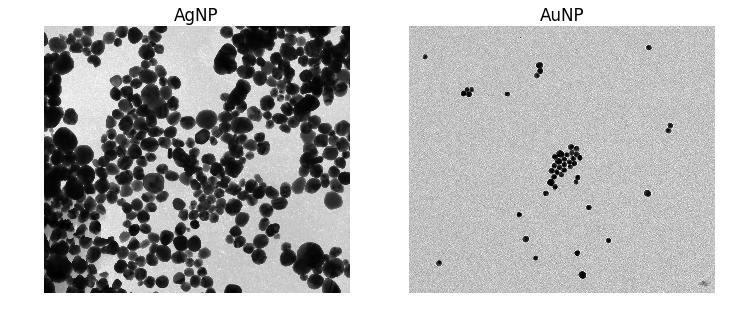

In [12]:
import warnings

def supprwarn():
    warnings.warn("user", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    supprwarn()

    agfull = io.imread('../Data/AgNP-12.tif')
    origag = agfull[4:-256,4:-4]
    aggray = img_as_ubyte(rgb2gray(origag))
    
    aufull = io.imread('../Data/AuNP-07.tif')
    origau = aufull[4:-256,4:-4]
    augray = img_as_ubyte(rgb2gray(origau))

plt.rc('font', size='14')
    
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for img,a,title in zip((aggray,augray),axes,['AgNP','AuNP']):
    a.axis('off')
    a.set_title(title)
    a.imshow(img, cmap='gray')

### Step 2. Reduce background noise
Invert the grayscale image so that the nanoparticles become regional maxima then apply the <i>h-dome</i> technique; (1) the image is subtracted by some threshold value <i>h</i> that is intended to isolate the maxima, (2) the resulting image is dilated, (3) the dilated image is subtracted from the original.

In the following steps, the AgNP image loaded above will be used to demonstrate the analysis procedure.


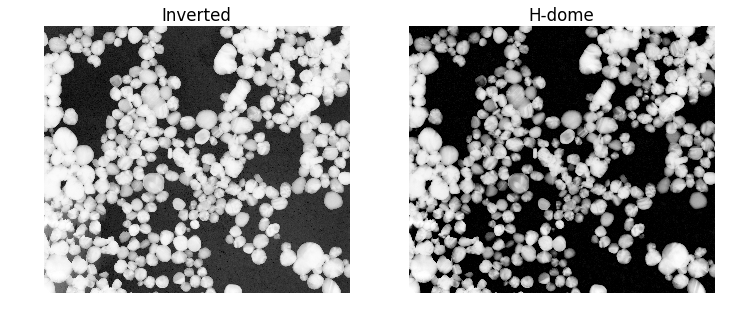

In [13]:
# Invert grayscale image to convert NPs to local maxima
imginv = np.copy(aggray)
imginv = np.invert(imginv)

# scipy gaussian filter requires floating point data
imggaus = img_as_float(imginv)
imggaus = gaussian_filter(imggaus, 1)

h = 0.5
seed = imggaus - h
mask = imggaus

dilated = reconstruction(seed, mask, method='dilation')

imghdome = imggaus - dilated

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.axis('off')
ax1.set_title('Inverted')
ax1.imshow(imginv, cmap='gray')
ax2.axis('off')
ax2.set_title('H-dome')
ax2.imshow(imghdome, cmap='gray')

### Step 3. Apply Laplacian of Gaussian blob detection to identify NPs

Calculating nanoparticle diameter is severly hampered by the aggregation that occurs during the evaporation step of sample preparation. Using a thresholding-approach will end up creating poorly-outlined nanoparticles that are difficult to isolate and measure. A region or edge-based segmentation approach also suffers from problems identifying these overlapping particles.

An alternative approach is to employ blob detection, a computer vision techniques used to identify regions within an image based on brightness or color. Here, the NPs have a strong contrast against the background of the TEM grid as the particles have a roughly spherical shape. In addition to identification of blobs (i.e., nanoparticles) the method will also give an estimate of the size of the blob.

In test runs, the LoP technique seemed to do a better job of identifying nanoparticles than the difference of Gaussian (DoG) and determinant of hessian (DoH). This is to be expected as LoP is known to be the slowest but most accurate of the three.

In [14]:
# Using the dilated grayscale image to better identify local maxima (i.e., particles)
# This technique is designed to reduce false positives due to background noise,
# by isolating the local maxima

kwargs = {}
kwargs['min_sigma'] = 25
kwargs['max_sigma'] = 50
kwargs['num_sigma'] = 25
kwargs['threshold'] = 0.01
kwargs['overlap'] = 0.4

# Using the laplacian of gaussians seems to work better than other blob detection schemes
blobsh = blob_log(imghdome, **kwargs)
# Convert gaussian sigma values to blob radii
blobsh[:, 2] = blobsh[:, 2] * sqrt(2)


Number of identified particles: 281



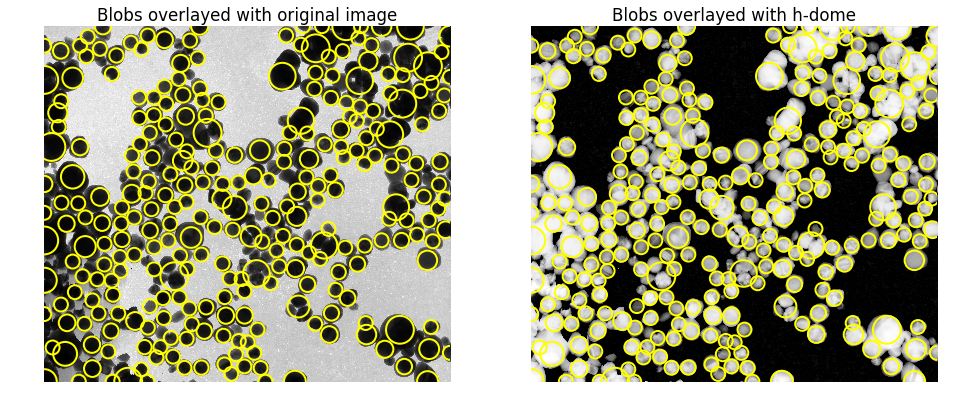

In [15]:
print('')
print('Number of identified particles:', blobsh.shape[0])
print('')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axis('off')
ax1.set_title('Blobs overlayed with original image')
ax1.imshow(aggray, cmap='gray')
for blob in blobsh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax1.add_patch(c)

ax2.axis('off')
ax2.set_title('Blobs overlayed with h-dome')
ax2.imshow(imghdome, cmap='gray')
for blob in blobsh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax2.add_patch(c)

#### Improvements with h-dome

Obviously from the above images, there may be a few misidentifications but overall the blobs seem to coincide with the expected outlines of the nanoparticles. Also,  blob detection assumes a perfect spheroidal shape while the NPs seem to be slightly prolate, this will introduce a little bit of error in the calculation as well.

Below is a quick comparison showing the results without using the h-dome computation. There are a few clear false positives coming from the background (TEM grid) that appear in this non-enhanced analysis.

In [16]:
# Using the non-dilated inverted grayscale image

blobsnon = blob_log(imginv, **kwargs)
# Convert gaussian sigma values to blob radii
blobsnon[:, 2] = blobsnon[:, 2] * sqrt(2)


Number of identified particles: 287



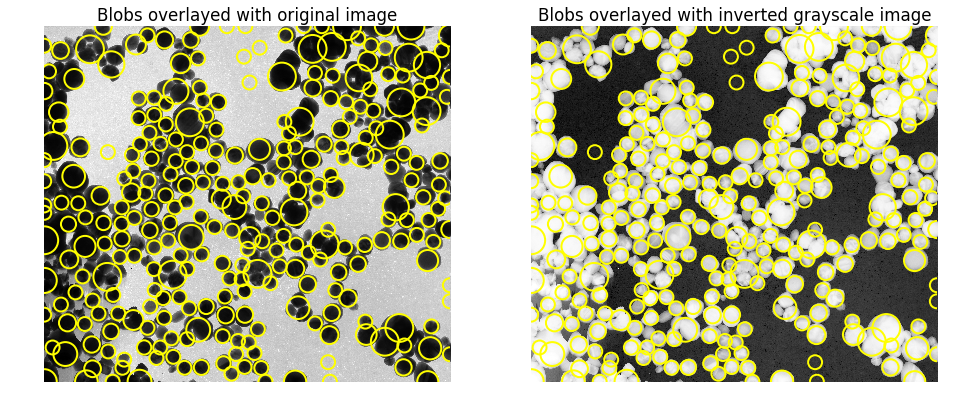

In [17]:
print('')
print('Number of identified particles:', blobsnon.shape[0])
print('')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axis('off')
ax1.set_title('Blobs overlayed with original image')
ax1.imshow(aggray, cmap='gray')
for blob in blobsnon:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax1.add_patch(c)

ax2.axis('off')
ax2.set_title('Blobs overlayed with inverted grayscale image')
ax2.imshow(imginv, cmap='gray')
for blob in blobsnon:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax2.add_patch(c)

#### Repeat with gold nanoparticle test image
Visual inspection of the TEM images suggests that AuNP have a smaller pixel diameter, so the blob detection parameters will need to be modified.

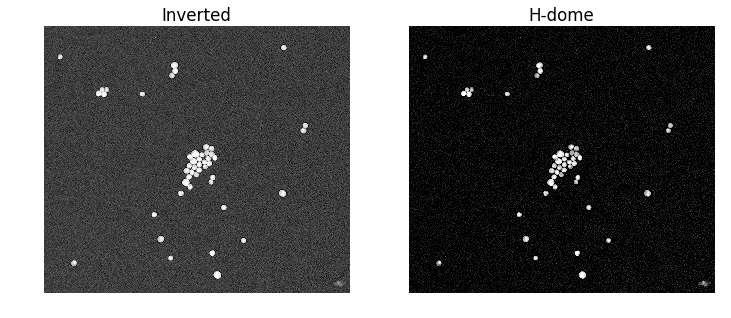

In [18]:
# Invert grayscale image to convert NPs to local maxima
imginv = np.copy(augray)
imginv = np.invert(imginv)

# scipy gaussian filter requires floating point data
imggaus = img_as_float(imginv)
imggaus = gaussian_filter(imggaus, 1)

h = 0.5
seed = imggaus - h
mask = imggaus

dilated = reconstruction(seed, mask, method='dilation')

imghdome = imggaus - dilated

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.axis('off')
ax1.set_title('Inverted')
ax1.imshow(imginv, cmap='gray')
ax2.axis('off')
ax2.set_title('H-dome')
ax2.imshow(imghdome, cmap='gray')

In [19]:
kwargs = {}
kwargs['min_sigma'] = 20
kwargs['max_sigma'] = 30
kwargs['num_sigma'] = 10
kwargs['threshold'] = 0.01
kwargs['overlap'] = 0.4

# Using the laplacian of gaussians seems to work better than other blob detection schemes
blobsau = blob_log(imghdome, **kwargs)
# Convert gaussian sigma values to blob radii
blobsau[:, 2] = blobsau[:, 2] * sqrt(2)


Number of identified particles: 26



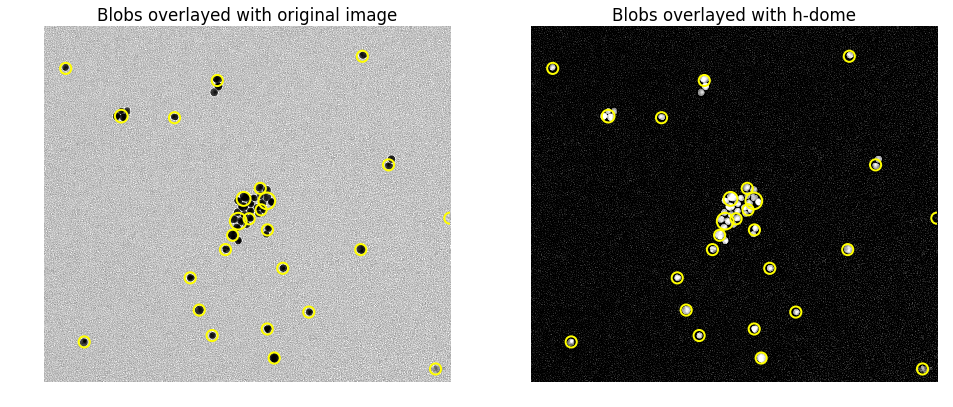

In [21]:
print('')
print('Number of identified particles:', blobsau.shape[0])
print('')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.axis('off')
ax1.set_title('Blobs overlayed with original image')
ax1.imshow(augray, cmap='gray')
for blob in blobsau:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax1.add_patch(c)

ax2.axis('off')
ax2.set_title('Blobs overlayed with h-dome')
ax2.imshow(imghdome, cmap='gray')
for blob in blobsau:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax2.add_patch(c)

### Step 4. Repeat for all other images

In [26]:
rdir = '/Volumes/TRANSFER/TEM/2015-10-15 - AuNP and AgNP/'
files = os.listdir(rdir)
# Sort out non images '*.tif'
srtf = [f for f in files if '.tif' in f]

# Not all files are useful due to shifting magnification scales, must manually input
manf = ['AgNP-01.tif','AgNP-02.tif','AgNP-03.tif','AgNP-04.tif','AgNP-05.tif','AgNP-06.tif']
manf.extend(['AgNP-07.tif','AgNP-11.tif','AgNP-12.tif'])
manf.extend(['AuNP-02.tif','AuNP-03.tif','AuNP-05.tif','AuNP-06.tif','AuNP-07.tif'])
manf.extend(['AuNP-08.tif','AuNP-09.tif','AuNP-10.tif'])

# Check all files are input correctly to prevent errors during runtime
presnt = all(f in srtf for f in manf)
print('Any typos in manual input file names:', str(not presnt))
typo = all('Au' in s or 'Ag' in s for s in manf)
print('Any typos in original file names:', str(not typo))

Any typos in manual input file names: False
Any typos in original file names: False


In [28]:
def temblob(filename,kwargs):
    
    orgfull = io.imread(rdir+filename)
    org = orgfull[4:-256,4:-4]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        supprwarn()
    
        igray = img_as_ubyte(rgb2gray(org))
        iinv = np.invert(igray)

    igaus = img_as_float(iinv)
    igaus = gaussian_filter(igaus, 1)
    h = 0.5
    sd = igaus - h
    msk = igaus
    dilat = reconstruction(sd, msk, method='dilation')
    hdome = igaus - dilat
    
    blobs = blob_log(hdome, **kwargs)
    diam = 2*sqrt(2)*blobs[:,-1]
    
    return(diam)
    
    
agdia = []
audia = []

kwargs = {}
kwargs['threshold'] = 0.01
kwargs['overlap'] = 0.4

for file in manf:

    if 'Ag' in file:
        kwargs['min_sigma'] = 25
        kwargs['max_sigma'] = 50
        kwargs['num_sigma'] = 25
        currdiam = temblob(file,kwargs)
        npdiam = currdiam*500/(969-26)
        agdia.extend(npdiam.tolist())
    
    elif 'Au' in file:
        kwargs['min_sigma'] = 20
        kwargs['max_sigma'] = 30
        kwargs['num_sigma'] = 10
        currdiam = temblob(file,kwargs)
        npdiam = currdiam*200/(777-23)
        audia.extend(npdiam.tolist())
    
    else:
        raise Exception('Unable to parse filename.')

### Step 5. Compile results
Visualize distribution of nanoparticles with hisgtogram and use pandas to prepare a table of values for each nanoparticle type.

Again note that there are likely a few false positives included these results. However steps were taken to minimize their influence.

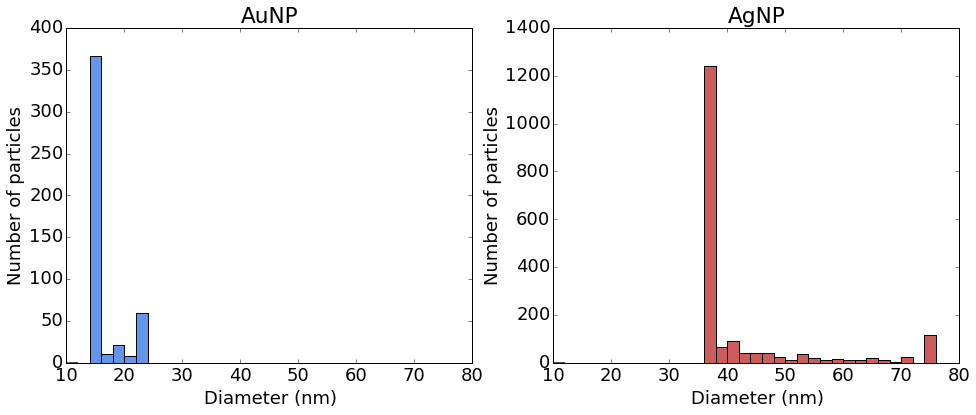

In [29]:
plt.rc('font', size='18')

bins = range(10,80,2)

fig, axes = plt.subplots(1,2, figsize=(16,6))
for a,title,sample,color in zip(axes, ('AuNP','AgNP'),
                                (audia, agdia), ('CornflowerBlue','IndianRed')):
    a.set_xlabel('Diameter (nm)')
    a.set_ylabel('Number of particles')
    a.set_title(title)
    _, _, _ = a.hist(sample, bins=bins, color=color)

In [30]:
# Statistical report

dfinal = pd.DataFrame([[len(audia)],[len(agdia)]], columns=['Total particles counted'], 
                      index=['AuNP','AgNP'])
dfinal['Mean Diameter (nm)'] = np.round([np.mean(audia),np.mean(agdia)],1)
dfinal['Median Diameter (nm)'] = np.round([np.median(audia),np.median(agdia)],1)
dfinal['Mode Diameter (nm)'] = np.round([mode(audia)[0],mode(agdia)[0]],1)

dfinal

,Total particles counted,Mean Diameter (nm),Median Diameter (nm),Mode Diameter (nm)
AuNP,465,16.3,15.0,15.0
AgNP,1847,43.0,37.5,37.5
